In [1]:
import torch

#imports necessary to define a neural network 
import torch.nn as nn
import torch.nn.functional as F

#ensure you are using GPU.
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)
print(device)

dtype = torch.cuda.FloatTensor
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

cuda:0


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(-0.5,0.5)])

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

/home/mohammad/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


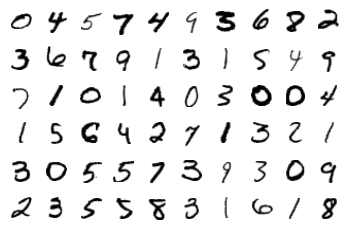

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = Net()
model.to(device)
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
logps = model(images.reshape([64,1,28,28]).cuda()) #log probabilities
loss = criterion(logps, labels.cuda()) #calculate the NLL loss

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # Training pass
        optimizer.zero_grad()
        
        output = model(images.reshape([-1,1,28,28]).cuda())
        loss = criterion(output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("\nTraining Time (in minutes) =",(time()-time0)/60)

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 0 - Training loss: 1.054487051581269

Training Time (in minutes) = 0.09986407359441121
Epoch 1 - Training loss: 0.4296170888361392

Training Time (in minutes) = 0.19950389862060547
Epoch 2 - Training loss: 0.34607321034267

Training Time (in minutes) = 0.30101222594579063
Epoch 3 - Training loss: 0.30589389079002177

Training Time (in minutes) = 0.40597699880599974
Epoch 4 - Training loss: 0.2773636725824525

Training Time (in minutes) = 0.509467613697052
Epoch 5 - Training loss: 0.258386384640167

Training Time (in minutes) = 0.6131433447202047
Epoch 6 - Training loss: 0.23890492706490096

Training Time (in minutes) = 0.7178377707799276
Epoch 7 - Training loss: 0.22986116852047347

Training Time (in minutes) = 0.8197766065597534
Epoch 8 - Training loss: 0.21903355783626025

Training Time (in minutes) = 0.9185047666231791
Epoch 9 - Training loss: 0.20840795196767556

Training Time (in minutes) = 1.0175398111343383
Epoch 10 - Training loss: 0.2015412354778284

Training Time (in mi

Predicted Digit = 7


<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


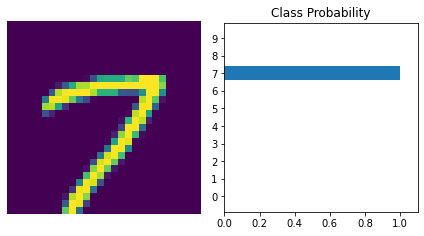

In [9]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
images, labels = next(iter(valloader))

img = images[0].reshape([-1,1,28,28])
with torch.no_grad():
    logps = model(img.cuda())

ps = torch.exp(logps)
probab = list(ps.detach().cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [10]:
torch.exp(model(img.cuda()))

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([[3.5439e-16, 7.0265e-19, 1.2701e-11, 1.0988e-10, 2.4161e-14, 8.6821e-11,
         3.1597e-23, 1.0000e+00, 6.5452e-14, 2.7657e-09]], device='cuda:0',
       grad_fn=<ExpBackward>)

In [11]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].reshape([-1,1,28,28])
    with torch.no_grad():
        logps = model(img.cuda())

    
    ps = torch.exp(logps)
    probab = list(ps.detach().cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Number Of Images Tested = 10000

Model Accuracy = 0.954


In [12]:
images.shape

torch.Size([16, 1, 28, 28])

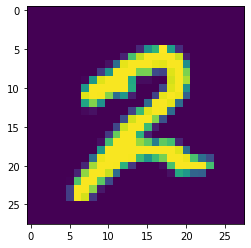

In [13]:
plt.imshow(img.detach().cpu().numpy().reshape(28,28))

In [40]:
def findloss(diff,pred):
    
#     diff is array of noise
#     pred is the prediction of the above trained model
    
    
    l1=(torch.square(diff))
    l1=torch.mean(l1)
    
    l2=pred**(-2)/1e6
    
    fl=l1+l2
    fl=fl**0.5
    
    return fl

In [45]:
diff=torch.rand([784]).cuda().requires_grad_()

In [46]:
learning_rate=0.00005
num_descents=2000000 #number of times gradient descent is employed

img=img.reshape(784).cuda()

for i in range(num_descents):
    
    imagef=img+diff
    pred=torch.exp(model(imagef.reshape([-1,1,28,28])))[0][8]
    totalloss=findloss(diff,pred)
    if i%10000 ==0:
        print('Loss and prediction by the model after '+str(i)+' steps of gradient descent are '+str(totalloss.item()),str(pred.item()))

    #find gradients of totalt wrt yarray.
    totalloss.backward()

    gradients=diff.grad
    with torch.no_grad():
        diff[1:]=diff[1:]-learning_rate*gradients[1:]
        
        
    diff.grad.data.zero_()

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Loss and prediction by the model after 0 steps of gradient descent are 10808.0185546875 9.252389787661741e-08
Loss and prediction by the model after 10000 steps of gradient descent are 0.604498028755188 0.4332927465438843
Loss and prediction by the model after 20000 steps of gradient descent are 0.6038746237754822 0.891646683216095
Loss and prediction by the model after 30000 steps of gradient descent are 0.6032688021659851 0.9950359463691711
Loss and prediction by the model after 40000 steps of gradient descent are 0.6026538014411926 0.8795837163925171
Loss and prediction by the model after 50000 steps of gradient descent are 0.6020654439926147 0.7398703098297119
Loss and prediction by the model after 60000 steps of gradient descent are 0.6014443635940552 0.7962536215782166
Loss and prediction by the model after 70000 steps of gradient descent are 0.6008274555206299 0.7059437036514282
Loss and prediction by the model after 80000 steps of gradient descent are 0.6002153158187866 0.88901

Loss and prediction by the model after 720000 steps of gradient descent are 0.5622149109840393 0.04217275604605675
Loss and prediction by the model after 730000 steps of gradient descent are 0.561100423336029 0.8522547483444214
Loss and prediction by the model after 740000 steps of gradient descent are 0.5605440139770508 0.3019934892654419
Loss and prediction by the model after 750000 steps of gradient descent are 0.559925377368927 0.9998465776443481
Loss and prediction by the model after 760000 steps of gradient descent are 0.5593173503875732 0.8898979425430298
Loss and prediction by the model after 770000 steps of gradient descent are 0.5587225556373596 0.6772152781486511
Loss and prediction by the model after 780000 steps of gradient descent are 0.5581380724906921 0.7555902004241943
Loss and prediction by the model after 790000 steps of gradient descent are 0.5575481653213501 0.6478776335716248
Loss and prediction by the model after 800000 steps of gradient descent are 0.55694991350

KeyboardInterrupt: 

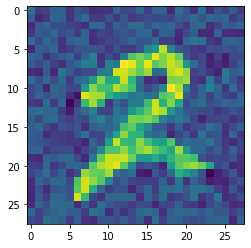

In [47]:
plt.imshow(imagef.detach().cpu().numpy().reshape(28,28))

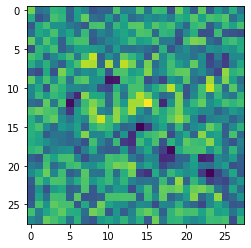

In [48]:
plt.imshow(diff.detach().cpu().numpy().reshape(28,28))

In [ ]:
learning_rate=0.00005
num_descents=6000000 #number of times gradient descent is employed

img=img.reshape(784).cuda()

for i in range(1080000,num_descents):
    
    imagef=img+diff
    pred=torch.exp(model(imagef.reshape([-1,1,28,28])))[0][8]
    totalloss=findloss(diff,pred)
    if i%10000 ==0:
        print('Loss and prediction by the model after '+str(i)+' steps of gradient descent are '+str(totalloss.item()),str(pred.item()))

    #find gradients of totalt wrt yarray.
    totalloss.backward()

    gradients=diff.grad
    with torch.no_grad():
        diff[1:]=diff[1:]-learning_rate*gradients[1:]
        
        
    diff.grad.data.zero_()

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Loss and prediction by the model after 1080000 steps of gradient descent are 0.5402336120605469 0.784903883934021
Loss and prediction by the model after 1090000 steps of gradient descent are 0.53965163230896 0.4908953309059143


In [ ]:
plt.imshow(imagef.detach().cpu().numpy().reshape(28,28))

In [ ]:
plt.imshow(diff.detach().cpu().numpy().reshape(28,28))